# Загружаем архив и датасет:

In [1]:
# подключаем гугл диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# проверяем, что у нас есть архив
!ls /content/drive/MyDrive/GNN/

deepmind-research-master.zip  test  tets_1


In [3]:
# рахархивируем архив
!unzip -q /content/drive/MyDrive/GNN/deepmind-research-master.zip

In [4]:
# создаем папки для загрузки датасета
!mkdir -p /tmp/rollous
!mkdir -p /tmp/datasets

In [5]:
# загружаем датасет
!bash /content/deepmind-research-master/learning_to_simulate/download_dataset.sh WaterRamps /tmp/datasets

--2022-03-15 08:05:00--  https://storage.googleapis.com/learning-to-simulate-complex-physics/Datasets/WaterRamps/metadata.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366 [application/octet-stream]
Saving to: ‘/tmp/datasets/WaterRamps/metadata.json’

/tmp/datasets/Water 100%[===================>]     366  --.-KB/s    in 0s      

2022-03-15 08:05:01 (84.5 MB/s) - ‘/tmp/datasets/WaterRamps/metadata.json’ saved [366/366]

--2022-03-15 08:05:01--  https://storage.googleapis.com/learning-to-simulate-complex-physics/Datasets/WaterRamps/train.tfrecord
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP requ

## Извлекаем данные из TFrecords

In [6]:
# переходим в дерикторию архива 
%cd /content/deepmind-research-master

/content/deepmind-research-master


In [7]:
import functools
import os
import json
import pickle

import tensorflow.compat.v1 as tf
import numpy as np

from learning_to_simulate import reading_utils

In [8]:
# Определяем путь к данным и имя файла
data_path = '/tmp/datasets/WaterRamps'
filename = 'train.tfrecord'

### Metadata

In [9]:
# Читаем metadata
def _read_metadata(data_path):
    with open(os.path.join(data_path, 'metadata.json'), 'rt') as fp:
        return json.loads(fp.read())

metadata = _read_metadata(data_path)

In [10]:
for key in metadata:
  print(key, metadata[key])

bounds [[0.1, 0.9], [0.1, 0.9]]
sequence_length 600
default_connectivity_radius 0.015
dim 2
dt 0.0025
vel_mean [-6.141567458658365e-08, -0.0007425391691160353]
vel_std [0.0022381126134429557, 0.0022664486850394443]
acc_mean [-1.713503820317499e-07, -2.1448168008479274e-07]
acc_std [0.00016824548701156486, 0.0001819676291787043]


In [11]:
# Определим глобальные переменные
CON_RAD = metadata['default_connectivity_radius'] ** 2
SEQ_LEN = metadata['sequence_length']

### Data

В массиве positons находятся позиции точек. positions.shape = [t_steps_num, nodes_num, dim]

In [12]:
ds_org = tf.data.TFRecordDataset([os.path.join(data_path, filename)])
ds = ds_org.map(functools.partial(reading_utils.parse_serialized_simulation_example, metadata=metadata))

In [13]:
particle_types = []
keys = []
positions = []
for i, _ds in enumerate(ds):
    context, features = _ds
    particle_types.append(context["particle_type"].numpy().astype(np.int64))
    keys.append(context["key"].numpy().astype(np.int64))
    positions.append(features["position"].numpy().astype(np.float32))
    if i > 101:
      break

In [14]:
res_set = set(particle_types[0])
for seq in particle_types:
  cur_set = set(seq)
  res_set = res_set | cur_set
print('Different values in patrical_types:')
print(res_set)

Different values in patrical_types:
{3, 5}


In [15]:
for i in range(len(particle_types)):
  for j in range(len(particle_types[i])):
    if particle_types[i][j] == 5:
      particle_types[i][j] = True
    else:
      particle_types[i][j] = False

In [16]:
print('Shape of each element in positions:')
print(positions[0].shape)

Shape of each element in positions:
(601, 1688, 2)


In [17]:
def get_borders_features(positions, borders):
  return np.concatenate(((positions[:, 0]-borders[0][0]).reshape(-1, 1), (borders[0][1]-positions[:, 0]).reshape(-1, 1), 
                         (positions[:, 1]-borders[1][0]).reshape(-1, 1), (borders[1][1]-positions[:, 1]).reshape(-1, 1)), axis=1)

Валидационная выборка

In [18]:
# Определяем путь к данным и имя файла
val_data_path = '/tmp/datasets/WaterRamps'
val_filename = 'valid.tfrecord'

In [19]:
ds_org = tf.data.TFRecordDataset([os.path.join(val_data_path, val_filename)])
ds = ds_org.map(functools.partial(reading_utils.parse_serialized_simulation_example, metadata=metadata))

In [20]:
val_particle_types = []
val_keys = []
val_positions = []
for i, _ds in enumerate(ds):
    context, features = _ds
    val_particle_types.append(context["particle_type"].numpy().astype(np.int64))
    val_keys.append(context["key"].numpy().astype(np.int64))
    val_positions.append(features["position"].numpy().astype(np.float32))
    if i > 101:
      break

In [21]:
for i in range(len(val_particle_types)):
  for j in range(len(val_particle_types[i])):
    if val_particle_types[i][j] == 5:
      val_particle_types[i][j] = True
    else:
      val_particle_types[i][j] = False

# GNN

## Загружаем torch.geometric, определяем библиотеки

In [22]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 7.9 MB 11.4 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 3.5 MB 11.4 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 2.5 MB 4.7 MB/s 
     |████████████████████████████████| 407 kB 14.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=6e3ee03ed20067f6e86f038a0d1775884025313db5e12f80ec34d41957ae134b
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [23]:
import torch
from torch import Tensor
from torch_geometric.nn import GCNConv, MessagePassing, EdgeConv, BatchNorm, GCN
from torch_cluster import knn_graph
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange
from tqdm import tqdm
from torch.optim import lr_scheduler

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Message passing net

### GNN

In [25]:
class GNN(MessagePassing):
    def __init__(self, in_channels, hidden_channels, k=100):
        super().__init__(aggr='add')

        self.gnn1_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn1 = EdgeConv(nn=self.gnn1_mlp, aggr='add')

        self.gnn2_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn2 = EdgeConv(nn=self.gnn2_mlp, aggr='add')

        self.gnn3_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn3 = EdgeConv(nn=self.gnn3_mlp, aggr='add')

        self.gnn4_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn4 = EdgeConv(nn=self.gnn4_mlp, aggr='add')

        self.gnn5_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn5 = EdgeConv(nn=self.gnn5_mlp, aggr='add')

        self.gnn6_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn6 = EdgeConv(nn=self.gnn5_mlp, aggr='add')

        self.gnn7_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn7 = EdgeConv(nn=self.gnn5_mlp, aggr='add')

        self.gnn8_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn8 = EdgeConv(nn=self.gnn5_mlp, aggr='add')

        self.gnn9_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn9 = EdgeConv(nn=self.gnn5_mlp, aggr='add')

        self.gnn10_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn10 = EdgeConv(nn=self.gnn5_mlp, aggr='add')

        self.mlp = nn.Sequential(
                       nn.Linear(2*(in_channels)-4, 2*hidden_channels),
                       nn.BatchNorm1d(2*hidden_channels),
                       nn.ReLU(),
                       nn.Linear(2*hidden_channels, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, hidden_channels)
                       )
        
        self.lin = nn.Sequential(
                       nn.Linear(in_channels+hidden_channels, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, 2)
                       )
        
        self.k = k

    def forward(self, x, nodes_mask):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        edge_index = knn_graph(x[:, :2], self.k, loop=True, flow=self.flow)

        new_embedding = x + self.gnn1(x, edge_index)
        new_embedding = new_embedding + self.gnn2(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn3(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn4(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn5(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn6(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn7(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn8(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn9(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn10(new_embedding, edge_index)

        return self.propagate(edge_index=edge_index, x=new_embedding, nodes_mask=nodes_mask, first_input=x.clone().detach())

    def message(self, x_i, x_j, nodes_mask):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]

        return self.mlp(torch.cat([x_i, x_i[:, :-5]-x_j[:, :-5], x_j[:, -1].reshape(-1,1)], dim=1))
      
    def update(self, aggr_out, nodes_mask, first_input):
        # aggr_out has shape [N, latent_size]

        new_embedding = torch.cat([first_input[nodes_mask], aggr_out[nodes_mask]], dim=1)
        new_embedding = self.lin(new_embedding)

        result = torch.zeros_like(first_input[:, :2])
        result[nodes_mask] = new_embedding
        
        return result

In [26]:
net_arch = '''
class GNN(MessagePassing):
    def __init__(self, in_channels, hidden_channels, k=100):
        super().__init__(aggr='add')

        self.gnn1_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn1 = EdgeConv(nn=self.gnn1_mlp, aggr='add')

        self.gnn2_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn2 = EdgeConv(nn=self.gnn2_mlp, aggr='add')

        self.gnn3_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn3 = EdgeConv(nn=self.gnn3_mlp, aggr='add')

        self.gnn4_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn4 = EdgeConv(nn=self.gnn4_mlp, aggr='add')

        self.gnn5_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn5 = EdgeConv(nn=self.gnn5_mlp, aggr='add')

        self.gnn6_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn6 = EdgeConv(nn=self.gnn5_mlp, aggr='add')

        self.gnn7_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn7 = EdgeConv(nn=self.gnn5_mlp, aggr='add')

        self.gnn8_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn8 = EdgeConv(nn=self.gnn5_mlp, aggr='add')

        self.gnn9_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn9 = EdgeConv(nn=self.gnn5_mlp, aggr='add')

        self.gnn10_mlp = nn.Sequential(
                       nn.Linear(2*in_channels, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, in_channels)
                       )

        self.gnn10 = EdgeConv(nn=self.gnn5_mlp, aggr='add')

        self.mlp = nn.Sequential(
                       nn.Linear(2*(in_channels)-4, 2*hidden_channels),
                       nn.BatchNorm1d(2*hidden_channels),
                       nn.ReLU(),
                       nn.Linear(2*hidden_channels, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, hidden_channels)
                       )
        
        self.lin = nn.Sequential(
                       nn.Linear(in_channels+hidden_channels, hidden_channels),
                       nn.BatchNorm1d(hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, hidden_channels//2),
                       nn.BatchNorm1d(hidden_channels//2),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//2, hidden_channels//4),
                       nn.BatchNorm1d(hidden_channels//4),
                       nn.ReLU(),
                       nn.Linear(hidden_channels//4, 2)
                       )
        
        self.k = k

    def forward(self, x, nodes_mask):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        edge_index = knn_graph(x[:, :2], self.k, loop=True, flow=self.flow)

        new_embedding = x + self.gnn1(x, edge_index)
        new_embedding = new_embedding + self.gnn2(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn3(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn4(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn5(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn6(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn7(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn8(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn9(new_embedding, edge_index)
        new_embedding = new_embedding + self.gnn10(new_embedding, edge_index)

        return self.propagate(edge_index=edge_index, x=new_embedding, nodes_mask=nodes_mask, first_input=x.clone().detach())

    def message(self, x_i, x_j, nodes_mask):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]

        return self.mlp(torch.cat([x_i, x_i[:, :-5]-x_j[:, :-5], x_j[:, -1].reshape(-1,1)], dim=1))
      
    def update(self, aggr_out, nodes_mask, first_input):
        # aggr_out has shape [N, latent_size]

        new_embedding = torch.cat([first_input[nodes_mask], aggr_out[nodes_mask]], dim=1)
        new_embedding = self.lin(new_embedding)

        result = torch.zeros_like(first_input[:, :2])
        result[nodes_mask] = new_embedding
        
        return result
'''

## Train function

### Train per step

In [27]:
def get_borders_features(positions, borders):
  return np.concatenate(((positions[:, 0]-borders[0][0]).reshape(-1, 1), (borders[0][1]-positions[:, 0]).reshape(-1, 1), 
                         (positions[:, 1]-borders[1][0]).reshape(-1, 1), (borders[1][1]-positions[:, 1]).reshape(-1, 1)), axis=1)

In [28]:
def build_scene(data, particle_types, inds, metadata, input_len, noise_scale):

  i, j = inds

  noise = np.random.normal(loc=1.0, scale=noise_scale, size=data[i][j].shape)

  features = torch.tensor(data[i][j], dtype=torch.float)

  for l in range(1, input_len):
    features = torch.cat([features, torch.tensor(data[i][j-l])], dim=1)

  features = torch.cat([features, torch.tensor(get_borders_features(data[i][j], metadata['bounds'])), 
                        torch.tensor(particle_types[i]).view(-1, 1)], dim=1)
  
  node_mask = torch.BoolTensor(particle_types[i])
  next_pos = torch.tensor(data[i][j+1])

  return features, node_mask, next_pos

In [29]:
def build_next_pos(data, pred, inds):

  i, j = inds
  cur_pos = torch.tensor(data[i][j], device=device, requires_grad=False)
  prev1_pos = torch.tensor(data[i][j-1], device=device, requires_grad=False)
  prev2_pos = torch.tensor(data[i][j-2], device=device, requires_grad=False)

  return cur_pos + (cur_pos-prev1_pos+pred)*metadata['dt'] + (cur_pos-2*prev1_pos+prev2_pos)*(metadata['dt']**2)

In [30]:
from torch.utils.data import DataLoader
import random
import time

def train_vel(model, optimizer, scheduler, criterion, epochs, train_data, particle_types_train, val_data, particle_types_val):

  model.eval()
  model.load_state_dict(torch.load('/content/drive/MyDrive/GNN/test/state_dict_model.pt'))

  train_losses = []
  val_losses = []
  lgr_losses = []

  train_inds = []
  for i in range(len(train_data)):
    for j in range(5, metadata['sequence_length']):
      train_inds.append((i, j))

  val_inds = []
  for i in range(len(val_data)):
    for j in range(5, metadata['sequence_length']):
      val_inds.append((i, j))

  for epoch in range(epochs):

    start_epoch = time.time()

    print('Epoch', epoch+1)

    model.train()
    seq_train_losses = []
    pred_lgr_seq_losses = []

    print('Train')

    # train_data.shape = [batches, SEQ_LEN, nodes_num, 2]
    random.shuffle(train_inds)
    for inds in tqdm(train_inds):

      features, node_mask, next_pos = build_scene(train_data, particle_types_train, inds, metadata, 3, 0.0003)

      features = features.to(device)
      node_mask = node_mask.to(device)
      true_pos = next_pos.to(device)

      optimizer.zero_grad()

      pred = model(features, node_mask)
      pred_pos = build_next_pos(train_data, pred, inds)

      pred_lgr_pos = build_next_pos(train_data, torch.zeros_like(pred), inds)
      pred_lgr_seq_losses.append(criterion(pred_lgr_pos[node_mask], true_pos[node_mask]).item())

      loss = criterion(pred_pos[node_mask], true_pos[node_mask])
      seq_train_losses.append(loss.item())
      loss.backward()

      optimizer.step()

    train_losses.append(np.mean(seq_train_losses))
    lgr_losses.append(np.mean(pred_lgr_seq_losses))
    print('Train loss:', train_losses[-1])
    print('Lgr loss:', lgr_losses[-1])

    with open("/content/drive/MyDrive/GNN/test/train_losses.txt", "a") as file:
      print(train_losses[-1], file=file)

    # validation
    model.eval()
    seq_val_losses = []

    print('Validation')

    random.shuffle(val_inds)
    with torch.no_grad():

      for inds in tqdm(val_inds):

        features, node_mask, next_pos = build_scene(val_data, particle_types_val, inds, metadata, 3, 0.0003)

        features = features.to(device)
        node_mask = node_mask.to(device)
        true_pos = next_pos.to(device)

        pred = model(features, node_mask)
        pred_pos = build_next_pos(val_data, pred, inds)
        
        loss = criterion(pred_pos[node_mask], true_pos[node_mask])
        seq_val_losses.append(loss.item())

    scheduler.step()

    val_losses.append(np.mean(seq_val_losses))
    print('Validation loss:', val_losses[-1])
    print('')

    with open("/content/drive/MyDrive/GNN/test/val_losses.txt", "a") as file:
      print(val_losses[-1], file=file)

    torch.save(model.state_dict(), '/content/drive/MyDrive/GNN/test/state_dict_model.pt')

    end_epoch = time.time()
    with open("/content/drive/MyDrive/GNN/test/time.txt", "a") as file:
      print(end_epoch-start_epoch, file=file)


  return train_losses, val_losses

## Train

### Data define

In [31]:
train_data = positions[:100]
particle_types_train = particle_types[:100]

val_data = val_positions[:10]
particle_types_val = val_particle_types[:10]

### Define GNN

In [32]:
torch.cuda.empty_cache()

In [33]:
gnn = GNN(in_channels=2 + 2*2 + 4 + 1, hidden_channels=128).to(device)
optimizer = torch.optim.Adam(gnn.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[3, 5, 7], gamma=1)
epochs = 10

In [34]:
with open("/content/drive/MyDrive/GNN/test/net_info.txt", "w") as file:
  print(net_arch, file=file)

In [35]:
total_params = sum(p.numel() for p in gnn.parameters())
with open("/content/drive/MyDrive/GNN/test/net_info.txt", "a") as file:
  print('TOTAL_PARAMS:', total_params, file=file)

In [36]:
with open("/content/drive/MyDrive/GNN/test/net_info.txt", "a") as file:
  print('LR_strat:', 'Adam', 'lr=1e-4', file=file)

In [37]:
#torch.save(gnn.state_dict(), '/content/drive/MyDrive/GNN/test/state_dict_model.pt')

### Train per step

In [ ]:
train_losses, val_losses = train_vel(gnn, optimizer, scheduler, criterion, epochs, train_data, particle_types_train, val_data, particle_types_val)

Epoch 1
Train


 12%|█▏        | 7007/59500 [47:10<5:53:44,  2.47it/s]

In [40]:
train_losses, val_losses = train_vel(gnn, optimizer, scheduler, criterion, epochs, train_data, particle_types_train, val_data, particle_types_val)

Epoch 1
Train


100%|██████████| 59500/59500 [6:39:18<00:00,  2.48it/s]


Train loss: 3.897840338169851e-07
Lgr loss: 5.496816965665625e-06
Validation


100%|██████████| 5950/5950 [28:16<00:00,  3.51it/s]


Validation loss: 1.9021054644883408e-07

Epoch 2
Train


100%|██████████| 59500/59500 [6:38:36<00:00,  2.49it/s]


Train loss: 2.5550190215785936e-07
Lgr loss: 5.496816965665625e-06
Validation


100%|██████████| 5950/5950 [28:12<00:00,  3.52it/s]


Validation loss: 1.778540843872574e-07

Epoch 3
Train


 14%|█▍        | 8227/59500 [55:03<5:43:06,  2.49it/s]


KeyboardInterrupt: ignored

### Figure

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)

ax.plot(range(1, epochs+1), train_losses, color='blue', label='train losses')
ax.plot(range(1, epochs+1), val_losses, color='red', label='validation losses')
ax.set_title('Losses per epoch:')
ax.legend()
plt.show()

# Посмотрим на предсказанную эволюцию 

## Предсказание следующего шага

In [ ]:
test_data = positions[1]
particle_types_test = particle_types[1]

In [ ]:
torch.tensor(positions[1][0]).shape

torch.Size([1179, 2])

In [ ]:
torch.tensor(positions[1][0]).shape

torch.Size([1179, 2])

In [ ]:
edge_index = knn_graph(torch.tensor(positions[1][0]), 15, loop=True)

In [ ]:
edge_index.shape

torch.Size([2, 17685])

In [ ]:
edge_index[-1]

tensor([   0,    0,    0,  ..., 1178, 1178, 1178])

In [ ]:
res = np.array(edge_index)
for i in res:
  ans = i[-15:]
  break
print(ans)
point = ans[0]
print(point)

[1178  353  259  370  296  526  357  607  295  517  309  178  260  692
  258]
1178


In [ ]:
test_data[1].shape

(1179, 2)

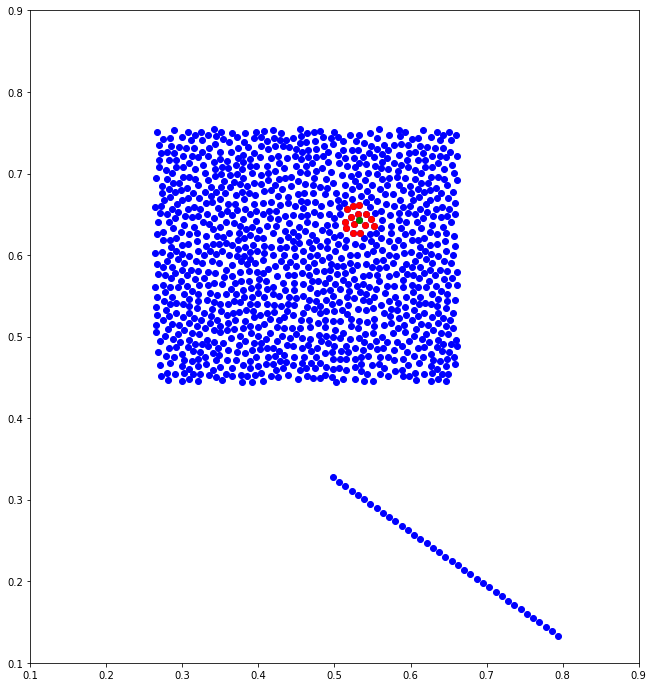

In [ ]:
fig = plt.figure(figsize=(24, 12))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(metadata['bounds'][0][0], metadata['bounds'][0][1])
ax1.set_ylim(metadata['bounds'][1][0], metadata['bounds'][1][1])

X = [test_data[1][j][0] for j in range(test_data[1].shape[0])]
Y = [test_data[1][j][1] for j in range(test_data[1].shape[0])]

X1 = [test_data[1][j][0] for j in ans]
Y1 = [test_data[1][j][1] for j in ans]

X2 = test_data[1][point][0]
Y2 = test_data[1][point][1]

ax1.scatter(X, Y, color='blue')
ax1.scatter(X1, Y1, color='red')
ax1.scatter(X2, Y2, color='green')

In [ ]:
for i in range(1, 100):

  fig = plt.figure(figsize=(24, 12))
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.set_xlim(metadata['bounds'][0][0], metadata['bounds'][0][1])
  ax1.set_ylim(metadata['bounds'][1][0], metadata['bounds'][1][1])

  X = [test_data[i][j][0] for j in range(test_data[i].shape[0]) if particle_types_test[j]==1]
  Y = [test_data[i][j][1] for j in range(test_data[i].shape[0]) if particle_types_test[j]==1]

  X_borders = [test_data[i][j][0] for j in range(test_data[i].shape[0]) if particle_types_test[j]==0]
  Y_borders = [test_data[i][j][1] for j in range(test_data[i].shape[0]) if particle_types_test[j]==0]

  edge_index = knn_graph(x[:, :2], self.k, loop=True, flow=self.flow)

  ax1.scatter(X, Y, color='blue')
  ax1.scatter(X_borders, Y_borders, color='red')

In [ ]:
for i in range(1, 100):

  fig = plt.figure(figsize=(24, 12))
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.set_xlim(metadata['bounds'][0][0], metadata['bounds'][0][1])
  ax1.set_ylim(metadata['bounds'][1][0], metadata['bounds'][1][1])

  X = [test_data[i][j][0] for j in range(test_data[i].shape[0]) if particle_types_test[j]==1]
  Y = [test_data[i][j][1] for j in range(test_data[i].shape[0]) if particle_types_test[j]==1]

  X_borders = [test_data[i][j][0] for j in range(test_data[i].shape[0]) if particle_types_test[j]==0]
  Y_borders = [test_data[i][j][1] for j in range(test_data[i].shape[0]) if particle_types_test[j]==0]

  ax1.scatter(X, Y, color='blue')
  ax1.scatter(X_borders, Y_borders, color='red')

  with torch.no_grad():

    nodes_mask = torch.BoolTensor(particle_types_test).to(device)
    input = torch.cat([torch.tensor(test_data[i-1], device=device), torch.tensor(particle_types_test, device=device).view(-1, 1)], dim=1)

    pred_img = cmpn.forward(input, nodes_mask).cpu()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_xlim(metadata['bounds'][0][0], metadata['bounds'][0][1])
    ax2.set_ylim(metadata['bounds'][1][0], metadata['bounds'][1][1])

    X = [pred_img[j][0].item() for j in range(pred_img.shape[0]) if particle_types_test[j]==1]
    Y = [pred_img[j][1].item() for j in range(pred_img.shape[0]) if particle_types_test[j]==1]

    X_borders = [pred_img[j][0].item() for j in range(pred_img.shape[0]) if particle_types_test[j]==0]
    Y_borders = [pred_img[j][1].item() for j in range(pred_img.shape[0]) if particle_types_test[j]==0]
    
    ax2.scatter(X, Y, color='blue')
    ax2.scatter(X_borders, Y_borders, color='red')

    clear_output(wait=True)
    plt.show()

## Предсказания на основе предыдущих

In [ ]:
def build_scene2(cur, last1, last2, particle_types, inds, metadata):

  i, j = inds

  features = torch.tensor(cur, dtype=torch.float)

  features = torch.cat([features, torch.tensor(last1)], dim=1)
  features = torch.cat([features, torch.tensor(last2)], dim=1)

  features = torch.cat([features, torch.tensor(get_borders_features(cur, metadata['bounds'])), 
                        torch.tensor(particle_types[i]).view(-1, 1)], dim=1)
  
  node_mask = torch.BoolTensor(particle_types[i])

  return features, node_mask

In [ ]:
target_ind = 7

In [ ]:
test_data = positions[target_ind]
particle_types_test = particle_types[target_ind]

In [ ]:
inp, node_mask = build_scene2(train_data[target_ind][2], train_data[target_ind][1], train_data[target_ind][0], particle_types_train, (target_ind, 2), metadata)
pred = gnn(inp.to(device), node_mask.to(device)).cpu()

cur_pos = torch.tensor(train_data[target_ind][2])
prev1_pos = torch.tensor(train_data[target_ind][1])
prev2_pos = torch.tensor(train_data[target_ind][0])
first_pos = cur_pos + (cur_pos-prev1_pos+pred)*metadata['dt'] + (cur_pos-2*prev1_pos+prev2_pos)*(metadata['dt']**2)

inp, node_mask = build_scene2(first_pos.detach().numpy(), train_data[target_ind][2], train_data[target_ind][1], particle_types_train, (target_ind, 2), metadata)
pred = gnn(inp.to(device), node_mask.to(device)).cpu()

cur_pos = first_pos
prev1_pos = torch.tensor(train_data[target_ind][2])
prev2_pos = torch.tensor(train_data[target_ind][1])
second_pos = cur_pos + (cur_pos-prev1_pos+pred)*metadata['dt'] + (cur_pos-2*prev1_pos+prev2_pos)*(metadata['dt']**2)

inp, node_mask = build_scene2(second_pos.detach().numpy(), first_pos.detach().numpy(), train_data[target_ind][2], particle_types_train, (target_ind, 2), metadata)
pred = gnn(inp.to(device), node_mask.to(device)).cpu()

cur_pos = second_pos
prev1_pos = first_pos
prev2_pos = torch.tensor(train_data[target_ind][2])
third_pos = cur_pos + (cur_pos-prev1_pos+pred)*metadata['dt'] + (cur_pos-2*prev1_pos+prev2_pos)*(metadata['dt']**2)

In [ ]:
for i in range(100):

  fig = plt.figure(figsize=(24, 12))
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.set_xlim(metadata['bounds'][0][0], metadata['bounds'][0][1])
  ax1.set_ylim(metadata['bounds'][1][0], metadata['bounds'][1][1])

  X = [test_data[i][j][0] for j in range(test_data[i].shape[0]) if particle_types_test[j]==1]
  Y = [test_data[i][j][1] for j in range(test_data[i].shape[0]) if particle_types_test[j]==1]

  X_borders = [test_data[i][j][0] for j in range(test_data[i].shape[0]) if particle_types_test[j]==0]
  Y_borders = [test_data[i][j][1] for j in range(test_data[i].shape[0]) if particle_types_test[j]==0]

  ax1.scatter(X, Y, color='blue')
  ax1.scatter(X_borders, Y_borders, color='red')

  with torch.no_grad():

    inp, node_mask = build_scene2(third_pos.detach().numpy(), second_pos.detach().numpy(), first_pos.detach().numpy(), particle_types_train, (target_ind, 2), metadata)
    pred = gnn(inp.to(device), node_mask.to(device)).cpu()

    cur_pos = third_pos
    prev1_pos = second_pos
    prev2_pos = first_pos
    new_pos = cur_pos + (cur_pos-prev1_pos+pred)*metadata['dt'] + (cur_pos-2*prev1_pos+prev2_pos)*(metadata['dt']**2)

    first_pos = second_pos
    second_pos = third_pos
    third_pos = new_pos

    pred_img = new_pos

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_xlim(metadata['bounds'][0][0], metadata['bounds'][0][1])
    ax2.set_ylim(metadata['bounds'][1][0], metadata['bounds'][1][1])

    X = [pred_img[j][0].item() for j in range(pred_img.shape[0]) if particle_types_test[j]==1]
    Y = [pred_img[j][1].item() for j in range(pred_img.shape[0]) if particle_types_test[j]==1]

    X_borders = [pred_img[j][0].item() for j in range(pred_img.shape[0]) if particle_types_test[j]==0]
    Y_borders = [pred_img[j][1].item() for j in range(pred_img.shape[0]) if particle_types_test[j]==0]
    
    ax2.scatter(X, Y, color='blue')
    ax2.scatter(X_borders, Y_borders, color='red')

    clear_output(wait=True)
    plt.show()

KeyboardInterrupt: ignored